## Setup

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import mannwhitneyu
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import requests
import zipfile
import os

In [2]:
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [3]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

In [4]:
max_date = interactions['last_watch_dt'].max()
last2weeks = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
last2weeks = last2weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})

C:\Users\Victo\AppData\Local\Temp\ipykernel_15848\3355431356.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  last2weeks = last2weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [5]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df, columns, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df[columns].drop_duplicates()


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))



def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


def get_mde(metric_vec, alpha, beta):
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    return mde*100/metric_mean

In [6]:
#last2weeks
print(last2weeks.shape)
last2weeks = last2weeks[(last2weeks['total_dur'] < last2weeks['total_dur'].std() * 3)]
print(last2weeks.shape)

(279129, 2)
(275616, 2)


## Bootstrap

### Significance

In [7]:
correctness = []
values = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)    

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

significance: 5.3%


Мы проводим A/A тест для того чтобы оценить корректность нашего подхода и проверить, найдёт ли бутстреп значительное различие в группах, в которых его нет (эффект не примешан). На 2х неделях мы получили результат в 5.3%, что достаточно неплохо, при обычном threshold в 5%. 5.3% конечно выше 5%, но в целом для real-world data не так плохо. На 1 неделе мы получали 6% из-за меньшего сэмпла, соответственно большей variability в данных. Все это означает, что бутстреп не нашёл принципиальной разницы между группами без эффекта, что вообщем то мы и ожидали. 

Text(0.5, 1.0, 'Бутстреп распределение p_value')

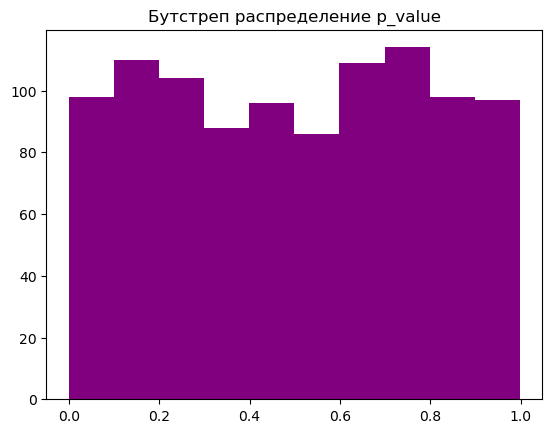

In [8]:
p_values = [get_p_value(dist) for dist in values]
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

### Power

Эффект в 1%

In [9]:
power = []
values = []

for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.01)  # докидаваем эффект в 1%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 32.6%


Эффект в 3%

In [10]:
power = []
values = []

for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.03)  # докидаваем эффект в 3%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 98.9%


Эффект в 5%

In [11]:
power = []
values = []

for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.05)  # докидаваем эффект в 5%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

power: 100.0%


Объяснение: power это вероятность правильно отказаться от нулевой гипотезы, когда различие в группах есть (подмешан или есть эффект). В этом контексте мы проводим три бутстрэп теста, подмешевая к группе B эффекты в 1%, 3% и 5%. В первом случае тест смог обнаружить значимое различие между группами A и B в 32.6% случаев, что означает, что он имеет довольно низкую мощность для небольшого эффекта. Мощность значительно увеличивается с возрастанием эффекта, как и должно быть. Тест смог обнаружить значимое различие в 98.9% случаев, когда реальное различие составляло 3%, и в 100% случаев при реальном различии в 5%. Это указывает на то, что тест будет явственно показывать разницу в случае больших эффектов, но не очень поведет себя если эффект небольшой.

## Design + metrics

In [12]:
last2weeks['total_dur_ln'] = np.log2(last2weeks['total_dur'])

### бутстреп + логарифмированная метрика длительности просмотров

In [13]:
correctness = []
values = []

for i in tqdm(range(1000)):

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur_ln', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur_ln']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur_ln']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

significance: 4.7%


Text(0.5, 1.0, 'Бутстреп распределение p_value c логарифмированной метрикой')

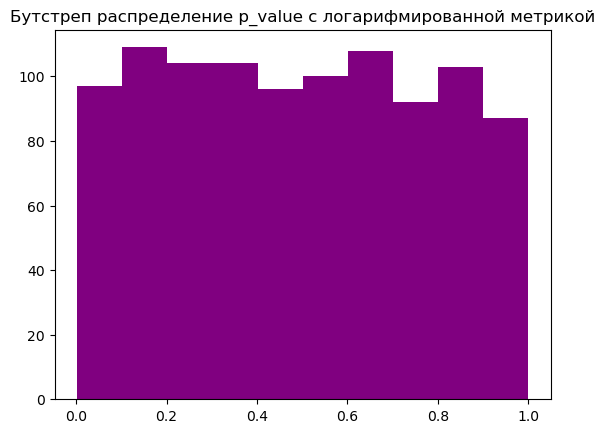

In [14]:
p_values = [get_p_value(dist) for dist in values]
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value c логарифмированной метрикой")

In [15]:
power_1 = []
values_1 = []

power_3 = []
values_3 = []


power_5 = []
values_5 = []


for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * np.log2(1+0.01)  # докидаваем эффект в 1

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values_1.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_1.append(not left_side <= 0 <= right_side)

    test_power_1 = collections.Counter(power_1)


print()
print(f'power with 1% effect: {test_power_1[1]/(test_power_1[1] + test_power_1[0])*100}%')



for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * np.log2(1+0.03)  # докидаваем эффект в 3

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values_3.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_3.append(not left_side <= 0 <= right_side)

    test_power_3 = collections.Counter(power_3)


print()
print(f'power with 3% effect: {test_power_3[1]/(test_power_3[1] + test_power_3[0])*100}%')


for i in tqdm(range(1000)): 

    new_df = groups_splitter(last2weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur'] 
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * np.log2(1+0.05)  # докидаваем эффект в 5

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values_5.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_5.append(not left_side <= 0 <= right_side)

    test_power_5 = collections.Counter(power_5)


print()
print(f'power with 3% effect: {test_power_5[1]/(test_power_5[1] + test_power_5[0])*100}%')


  0%|          | 0/1000 [00:00<?, ?it/s]


power with 1% effect: 100.0%


  0%|          | 0/1000 [00:00<?, ?it/s]


power with 3% effect: 100.0%


  0%|          | 0/1000 [00:00<?, ?it/s]


power with 3% effect: 100.0%


Выводы: при логарифмировании метрики, мы получаем лучшие метрики, и касательно корректности, и касательно мощности. Significance у бутстрепа с логарифмированной метрикой 4.7%, что ниже стандартного threshold в 5% и ниже показателей бутстрепа без логарифмирования, что означает, что бутстреп не находит значимого различия в группах, если этого значимого различия нет. Мощность же с логарифмированной метрикой и при эффекте 1%, и при эффекте 3%, и при эффекте 5% - 100%, что означает, что эффекты любого типа будут замечены бутстрепом если они логарифмированны.

### манна-уитни + метрика длительности просмотров

  0%|          | 0/1000 [00:00<?, ?it/s]

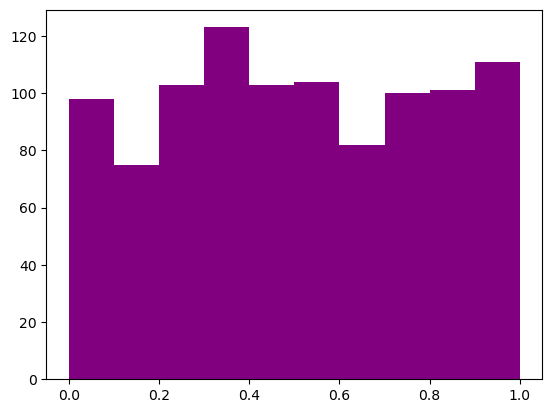

In [16]:
pvalues = []

for i in tqdm(range(1000)):

  last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

  u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values
    )
  pvalues.append(p)

print()
plt.hist(pvalues, bins=10, color='purple');

In [17]:
pvalues = np.array(pvalues)
print(f"Корректность = {pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]}")

Корректность = 0.042


In [18]:
p_values_1 = []
p_values_3 = []
p_values_5 = []


for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.01)
    )
    p_values_1.append(p)

p_values_1 = np.array(p_values_1)

print()
print(f"Мощность с эффектом 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.03)
    )
    p_values_3.append(p)

p_values_3 = np.array(p_values_3)

print()
print(f"Мощность с эффектом 3% = {p_values_3[p_values_3 < 0.05].shape[0] / p_values_3.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.05)
    )
    p_values_5.append(p)

p_values_5 = np.array(p_values_5)

print()
print(f"Мощность с эффектом 5% = {p_values_5[p_values_5 < 0.05].shape[0] / p_values_5.shape[0]}")

  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 1% = 0.239


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 3% = 0.959


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 5% = 1.0


Выводы: манна-уитни - непараметрический тест, который не предполагает нормального распределения, однако показывает себя не очень хорошо в случаях со многими повторяющимися значениями, потому что это критерий ранговый. Significance в 4.2% (ниже 5%) означает, что тест не найдет разницы между группами, когда статистически значимого эффекта нет, что делает его применимым, однако его мощность для маленьких эффектов - низка, при 1% мощность всего 0.239.

### манна-уитни + логарифмированная метрика длительности просмотров

  0%|          | 0/1000 [00:00<?, ?it/s]

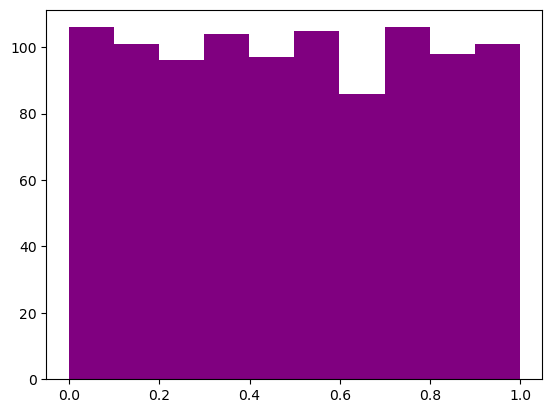

In [19]:
pvalues = []

for i in tqdm(range(1000)):  

  last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur_ln', 'group'])

  u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur_ln'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur_ln'].values
    )
  pvalues.append(p)

print()
plt.hist(pvalues, bins=10, color='purple');

In [20]:
pvalues = np.array(pvalues)
print(f"Корректность = {pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]}")

Корректность = 0.061


In [21]:
p_values_1 = []
p_values_3 = []
p_values_5 = []


for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur_ln', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur_ln'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur_ln'].values * np.log2(1+0.01)
    )
    p_values_1.append(p)

p_values_1 = np.array(p_values_1)

print()
print(f"Мощность с эффектом 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur_ln', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur_ln'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur_ln'].values * np.log2(1+0.03)
    )
    p_values_3.append(p)

p_values_3 = np.array(p_values_3)

print()
print(f"Мощность с эффектом 3% = {p_values_3[p_values_3 < 0.05].shape[0] / p_values_3.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur_ln', 'group'])

    u, p = mannwhitneyu(
        last2weeks_split[last2weeks_split['group'] == 'A']['total_dur_ln'].values,
        last2weeks_split[last2weeks_split['group'] == 'B']['total_dur_ln'].values * np.log2(1+0.05)
    )
    p_values_5.append(p)

p_values_5 = np.array(p_values_5)

print()
print(f"Мощность с эффектом 5% = {p_values_5[p_values_5 < 0.05].shape[0] / p_values_5.shape[0]}")

  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 1% = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 3% = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 5% = 1.0


Выводы: проводя теста манна-уитни на логарифмированной метрике мы заметим, что мощность почти 100%, что хорошо и означает, что почти любой эффект будет задетекчен. 
Однако так же видно, что что significance составляет 6,1%, что выше предыдущих версий с бутстрапом и ощутимо выше, чем принятая мера в 5%, хотя и не так катастрофично.

### t-test + метрика длительности просмотров

  0%|          | 0/1000 [00:00<?, ?it/s]

Корректность = 0.055


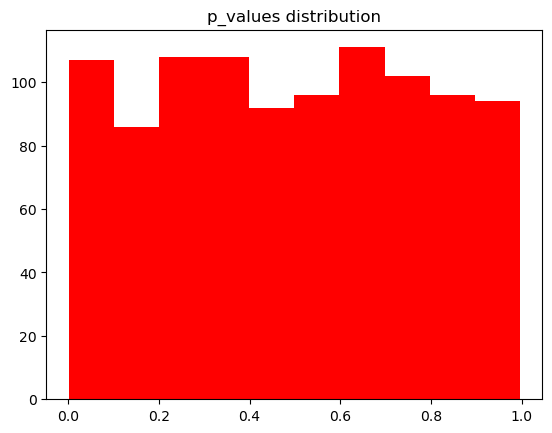

In [22]:
p_values = []


for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[(last2weeks_split['group'] == 'A')]['total_dur'].values, 
                              last2weeks_split[(last2weeks_split['group'] == 'B')]['total_dur'].values).pvalue

    p_values.append(p)

p_values = np.array(p_values)

print(f"Корректность = {p_values[p_values < 0.05].shape[0] / p_values.shape[0]}")

plt.hist(p_values, color='red');
plt.title('p_values distribution');

In [24]:
p_values_1 = []
p_values_3 = []
p_values_5 = []



for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.01)).pvalue

    p_values_1.append(p)

p_values_1 = np.array(p_values_1)

print()
print(f"Мощность для эффекта 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")


print()
print(f"Мощность с эффектом 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.03)).pvalue

    p_values_3.append(p)

p_values_3 = np.array(p_values_3)

print()
print(f"Мощность с эффектом 3% = {p_values_3[p_values_3 < 0.05].shape[0] / p_values_3.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * (1+0.05)).pvalue

    p_values_5.append(p)

p_values_5 = np.array(p_values_5)

print()
print(f"Мощность с эффектом 5% = {p_values_5[p_values_5 < 0.05].shape[0] / p_values_5.shape[0]}")

  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность для эффекта 1% = 0.292

Мощность с эффектом 1% = 0.292


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 3% = 0.994


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 5% = 1.0


Сразу следует отметить, что t-test предполагает обязательное условие нормальности распределения. На очень больших данных мы можем принебречь этим условием, ссылаясь на центральную предельную теорему, с учетом того, что сэмплы всё равно будут распределены нормально. Трудно сказать, что у нас прям обилие данных, однако их и не мало.

Мы видим, что significance - 5,5%, что слегка выше стандартных 5%.
Однако мощность не очень сильных эффектов низка, всего лишь 0.292 для эффекта в 1%, однако для 3% и 5% - довольно высокая, 94% и 100% соответственно. 

### t-test + логарифмированная метрика длительности просмотров

  0%|          | 0/1000 [00:00<?, ?it/s]

Корректность = 0.038


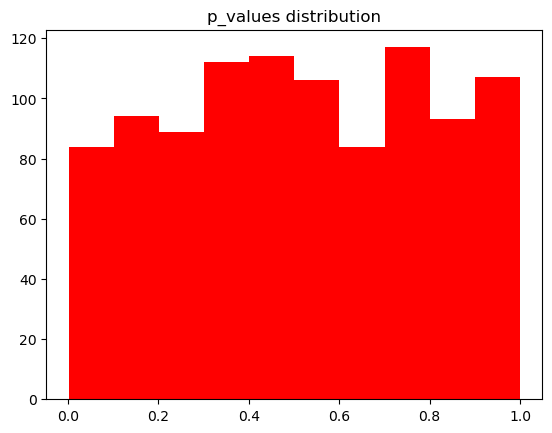

In [25]:
p_values = []


for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur_ln', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[(last2weeks_split['group'] == 'A')]['total_dur_ln'].values, 
                              last2weeks_split[(last2weeks_split['group'] == 'B')]['total_dur_ln'].values).pvalue

    p_values.append(p)

p_values = np.array(p_values)

print(f"Корректность = {p_values[p_values < 0.05].shape[0] / p_values.shape[0]}")

plt.hist(p_values, color='red');
plt.title('p_values distribution');

In [26]:
p_values_1 = []
p_values_3 = []
p_values_5 = []



for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * np.log2(1+0.01)).pvalue

    p_values_1.append(p)

p_values_1 = np.array(p_values_1)

print()
print(f"Мощность для эффекта 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")


print()
print(f"Мощность с эффектом 1% = {p_values_1[p_values_1 < 0.05].shape[0] / p_values_1.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * np.log2(1+0.03)).pvalue

    p_values_3.append(p)

p_values_3 = np.array(p_values_3)

print()
print(f"Мощность с эффектом 3% = {p_values_3[p_values_3 < 0.05].shape[0] / p_values_3.shape[0]}")

for _ in tqdm(range(1000)):

    last2weeks_split = groups_splitter(last2weeks, columns=['user_id', 'total_dur', 'group'])

    p = scipy.stats.ttest_ind(last2weeks_split[last2weeks_split['group'] == 'A']['total_dur'].values,
                             last2weeks_split[last2weeks_split['group'] == 'B']['total_dur'].values * np.log2(1+0.05)).pvalue

    p_values_5.append(p)

p_values_5 = np.array(p_values_5)

print()
print(f"Мощность с эффектом 5% = {p_values_5[p_values_5 < 0.05].shape[0] / p_values_5.shape[0]}")

  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность для эффекта 1% = 1.0

Мощность с эффектом 1% = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 3% = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]


Мощность с эффектом 5% = 1.0


Выводы: логарифмирование метрики позволило значительно улучшить результаты для t-test. 
Корректность составляет 3.8%, что значительно ниже 5% порога, в то время, как мощность с любым добавленным эффектом - 100%.

### Общий вывод

Зачем логарифмируем метрику: 

1) Помогает приблизить распределение к нормальному, делая его более симметричным для оных с большим хвостом.

2) Уменьшает влияние выбросов

3) Упрощение интерпретации потому что интерпретируем относительные изменения

4) Стабилизация дисперсии

Варианты, которые точно не подходят: 

1) Bootstrap на нелогарифмированную метрику (высоковат significance, низкая мощность для малых эффектов)

2) Манна-Уитни на нелогарифмированную метрику (низкая мощность для малых эффектов)

3) T-тест на нелогарифмированную метрику (вообще изначально не соблюдается assumption о нормальном распределении, кроме этого высокий significance, низкая мощность для малых эффектов)


Выбор критерий + метрика: в итоге я бы выбрал t-test на логарифмированной метрике. 

У этого критерия высокая мощность, что позволяет отловить даже незначительные изменения в данных, очень низкая вероятность ошибки первого рода, а благодаря логарифмированию метрики мы приближаемся к нормальному распределению, что в целом позволяет нам сделать вид, что assumption о нормальности распределения соблюдено.


### MDE

In [34]:
splitted = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
splitted = splitted.groupby('user_id', as_index=False).agg({'total_dur': sum})
splitted = groups_splitter(splitted, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator(salt='kiontestmodel20210805')).drop_duplicates()
mde = get_mde(splitted['total_dur'], alpha=0.05, beta=0.2)
print(mde)

C:\Users\Victo\AppData\Local\Temp\ipykernel_15848\411558736.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  splitted = splitted.groupby('user_id', as_index=False).agg({'total_dur': sum})


1.804622925885654


Объяснение: MDE помогает понять, насколько чувствителен  тест и какие эффекты можно  обнаружить при заданных альфа и бета. Результат  означает, что  тест чувствителен к эффектам, которые не менее чем на 1.804622 единицы отличаются от нулевого эффекта.

## A/B test

In [109]:
abdata = last2weeks

In [110]:
abdata.loc[abdata['total_dur'] < 500, ['total_dur']] = 0

In [111]:
absplitted = groups_splitter(abdata, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator(salt='kiontestmodel20210805')).drop_duplicates()

In [99]:
group_b = absplitted[absplitted['group'] == 'B']
cutoff = group_b['total_dur'].quantile(0.9)
top_10_percent = group_b[group_b['total_dur'] > cutoff]
absplitted.loc[top_10_percent.index, 'total_dur'] *= 1.025

C:\Users\Victo\AppData\Local\Temp\ipykernel_15848\3176841327.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 53352.275  65216.65   48854.575 ...  63776.525 126872.45   79733.725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  absplitted.loc[top_10_percent.index, 'total_dur'] *= 1.025


In [101]:
absplitted['log_total_dur'] = np.log2(absplitted['total_dur'] + 1e-6)

In [107]:
t_statistic, p_value = scipy.stats.ttest_ind(absplitted[(absplitted['group'] == 'A')]['log_total_dur'].values, 
                              absplitted[(absplitted['group'] == 'B')]['log_total_dur'].values)

alpha = 0.05

print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis. The new thing is performing significantly better.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")

t-statistic: 0.7711935737259092
P-value: 0.44059286381950236
Fail to reject the null hypothesis. There is no significant difference.


Выводы к A/B тесту:

Честно говоря, я не смог найти причину, почему p-value получается столь высокий и мы вынуждены придерживаться нулевой гипотезы. Как будто бы по логике задания у нас разница не является случайным шумом и должна быть отражена в A/B тесте. 

Однако тест показывает, что разница не является статистически значимой, соответственно не выходит за пределы стат. погрешности.
Из теста следует, что введение изменения принципиально не повлияло на ключевую метрику, соответственно изменение не имеет смысла.

Интуитивно мне кажется, что либо тест оказался недостаточно мощным, либо я где-то ошибся в рассчетах и преобразованиях. Но ошибку найти не могу.